Predictive Patient Satisfaction in Hospital Services
This Jupyter Notebook performs a classification task to predict whether a patient's satisfaction is high (≥80) or low (<80) based on hospital data. We use datasets including patient details, weekly service metrics, and staff schedules. The analysis follows the specified steps for data handling, pre-processing, handling class imbalance, EDA, model training, evaluation, and conclusion.

In [3]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

In [5]:
base_folder = os.path.expanduser("~/Downloads/archive (1)")

# List files to verify
print("Files found in the folder:")
for f in os.listdir(base_folder):
    print("  →", f)

# Load the three CSV files
patients_path        = os.path.join(base_folder, "patients.csv")
services_path        = os.path.join(base_folder, "services_weekly.csv")
staff_schedule_path  = os.path.join(base_folder, "staff_schedule.csv")
staff_path           = os.path.join(base_folder, "staff.csv")

patients        = pd.read_csv(patients_path)
services        = pd.read_csv(services_path)
staff_schedule  = pd.read_csv(staff_schedule_path)
staff           = pd.read_csv(staff_path)

print("\nDatasets loaded successfully!")
print(f"Patients: {patients.shape} | Services weekly: {services.shape} | Staff schedule: {staff_schedule.shape} | Staff list: {staff.shape}")

Files found in the folder:
  → .ipynb_checkpoints
  → patients.csv
  → services_weekly.csv
  → staff.csv
  → staff_schedule.csv

Datasets loaded successfully!
Patients: (1000, 7) | Services weekly: (208, 10) | Staff schedule: (6552, 6) | Staff list: (110, 4)


In [9]:
# Explore patients
print(patients.info())
print(patients.describe())
print(patients['service'].value_counts())

# Binarize target for classification
patients['high_satisfaction'] = (patients['satisfaction'] >= 80).astype(int)
print(patients['high_satisfaction'].value_counts(normalize=True))  # Class distribution

# Explore services
print(services.info())
print(services['event'].value_counts())

# Explore staff_schedule
print(staff_schedule.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patient_id         1000 non-null   object
 1   name               1000 non-null   object
 2   age                1000 non-null   int64 
 3   arrival_date       1000 non-null   object
 4   departure_date     1000 non-null   object
 5   service            1000 non-null   object
 6   satisfaction       1000 non-null   int64 
 7   high_satisfaction  1000 non-null   int32 
dtypes: int32(1), int64(2), object(5)
memory usage: 58.7+ KB
None
               age  satisfaction  high_satisfaction
count  1000.000000   1000.000000        1000.000000
mean     45.337000     79.597000           0.505000
std      25.999912     11.550325           0.500225
min       0.000000     60.000000           0.000000
25%      23.000000     70.000000           0.000000
50%      46.000000     80.000000           1.00

In [11]:
#Data Pre-processing
# Parse dates and compute length of stay and week
patients['arrival_date'] = pd.to_datetime(patients['arrival_date'])
patients['departure_date'] = pd.to_datetime(patients['departure_date'])
patients['length_stay'] = (patients['departure_date'] - patients['arrival_date']).dt.days
patients['week'] = ((patients['arrival_date'] - pd.to_datetime('2025-01-01')).dt.days // 7) + 1
patients['week'] = np.minimum(patients['week'], 52)

# Staff counts per week/service/role
staff_counts = staff_schedule.groupby(['week', 'service', 'role'])['present'].sum().reset_index(name='count')
staff_pivot = staff_counts.pivot(index=['week', 'service'], columns='role', values='count').fillna(0).reset_index()
staff_pivot.rename(columns={'doctor': 'num_doctors', 'nurse': 'num_nurses', 'nursing_assistant': 'num_nursing_assistants'}, inplace=True)

# Merge staff counts to patients
patients = patients.merge(staff_pivot, on=['week', 'service'], how='left').fillna(0)  # Impute 0 for missing counts

# Select and merge service metrics
services_subset = services[['week', 'service', 'available_beds', 'patients_refused', 'staff_morale', 'event']]
patients = patients.merge(services_subset, on=['week', 'service'], how='left').fillna(method='ffill')  # Forward fill if any missing

# Check for remaining missing values
print(patients.isna().sum())

# Features and target
features = ['age', 'length_stay', 'num_doctors', 'num_nurses', 'num_nursing_assistants', 'available_beds', 'patients_refused', 'staff_morale', 'service', 'event']
X = patients[features]
y = patients['high_satisfaction']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessor
numerical = ['age', 'length_stay', 'num_doctors', 'num_nurses', 'num_nursing_assistants', 'available_beds', 'patients_refused', 'staff_morale']
categorical = ['service', 'event']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

patient_id                0
name                      0
age                       0
arrival_date              0
departure_date            0
service                   0
satisfaction              0
high_satisfaction         0
length_stay               0
week                      0
num_doctors               0
num_nurses                0
num_nursing_assistants    0
available_beds            0
patients_refused          0
staff_morale              0
event                     0
dtype: int64


               age  length_stay  num_doctors   num_nurses  \
count  1000.000000  1000.000000  1000.000000  1000.000000   
mean     45.337000     7.407000     3.134000    10.649000   
std      25.999912     3.953857     2.716509     8.163482   
min       0.000000     1.000000     0.000000     0.000000   
25%      23.000000     4.000000     0.000000     0.000000   
50%      46.000000     7.000000     3.000000    14.000000   
75%      68.000000    11.000000     5.000000    17.000000   
max      89.000000    14.000000     8.000000    22.000000   

       num_nursing_assistants  available_beds  patients_refused  staff_morale  \
count             1000.000000     1000.000000       1000.000000   1000.000000   
mean                 4.506000       30.632000         36.394000     72.397000   
std                  3.517149       14.912309         52.737292     15.319141   
min                  0.000000        8.000000          0.000000     31.000000   
25%                  0.000000       18.000000

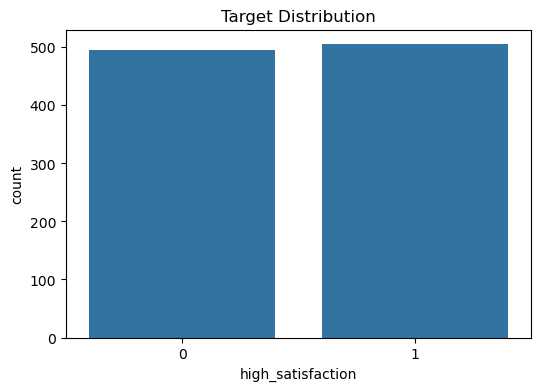

<Figure size 1000x600 with 0 Axes>

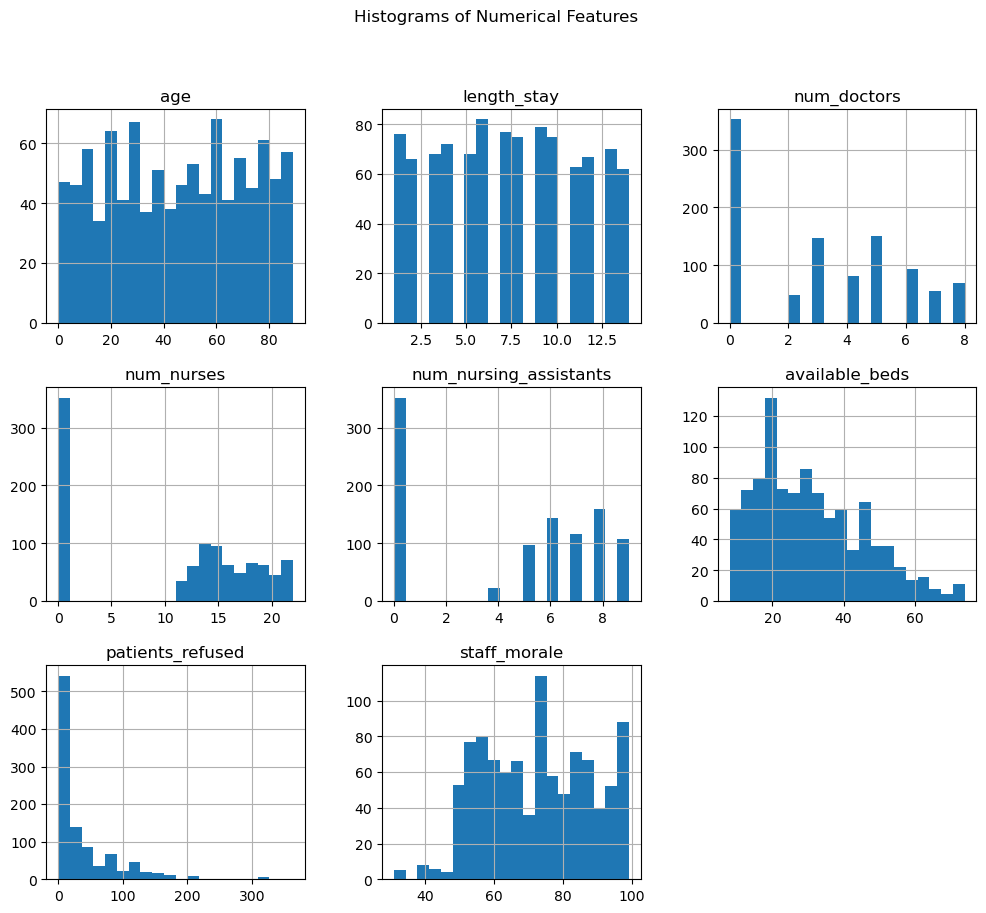

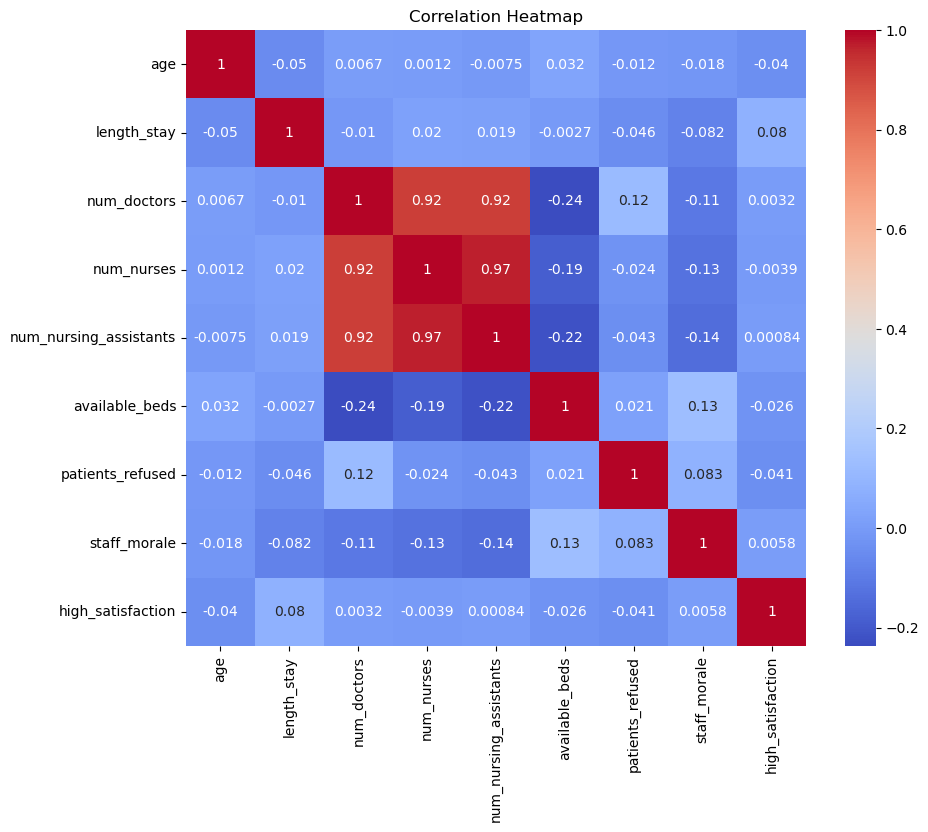

In [13]:
#Descriptive Statistics & EDA
# Summary statistics
print(patients[features + ['high_satisfaction']].describe())
print(patients.info())

# Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x='high_satisfaction', data=patients)
plt.title('Target Distribution')
plt.show()

plt.figure(figsize=(10,6))
patients[numerical].hist(bins=20, figsize=(12,10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Correlation heatmap
corr = patients[numerical + ['high_satisfaction']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [15]:
#Model Training
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    # Cross-validation
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')
    print(f'{name} CV F1: {cv_scores.mean():.4f}')
    
    # Fit on train
    pipe.fit(X_train, y_train)
    
    # Predict on test
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

Logistic Regression CV F1: 0.5162
SVM CV F1: 0.5086
Decision Tree CV F1: 0.5391
Random Forest CV F1: 0.5249
KNN CV F1: 0.5469


                     accuracy  precision    recall        f1   roc_auc
Logistic Regression     0.460   0.464646  0.455446  0.460000  0.476448
SVM                     0.510   0.517241  0.445545  0.478723  0.491549
Decision Tree           0.525   0.532609  0.485149  0.507772  0.525403
Random Forest           0.530   0.534653  0.534653  0.534653  0.518252
KNN                     0.505   0.510204  0.495050  0.502513  0.519452

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.46      0.46        99
           1       0.46      0.46      0.46       101

    accuracy                           0.46       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.46      0.46       200



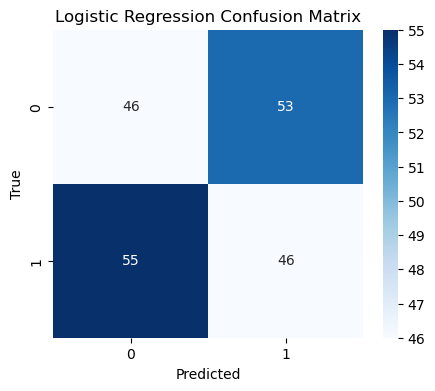

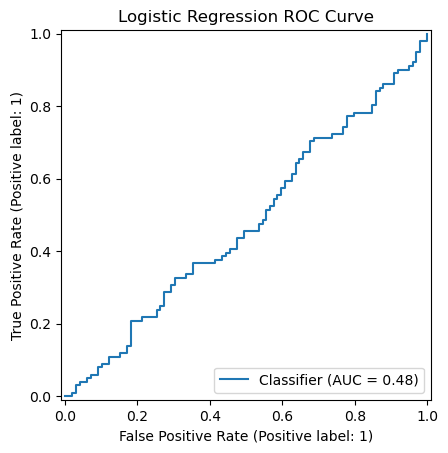


SVM Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.58      0.54        99
           1       0.52      0.45      0.48       101

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



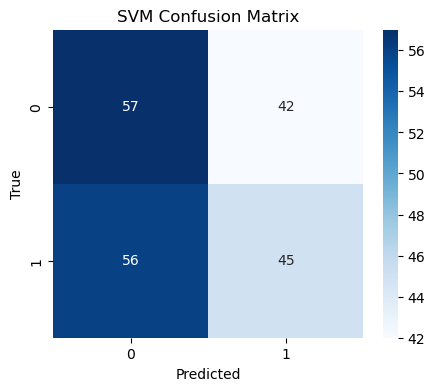

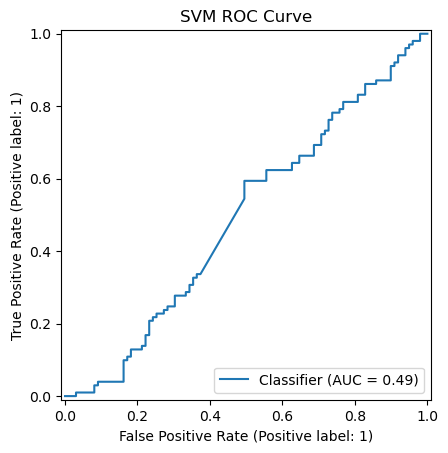


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.57      0.54        99
           1       0.53      0.49      0.51       101

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.52       200
weighted avg       0.53      0.53      0.52       200



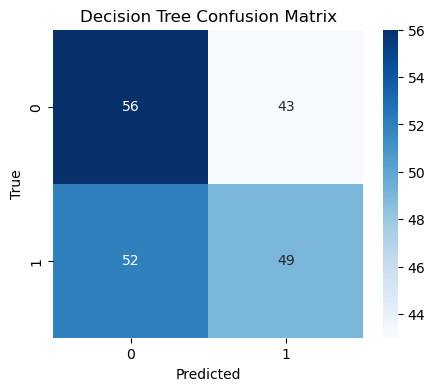

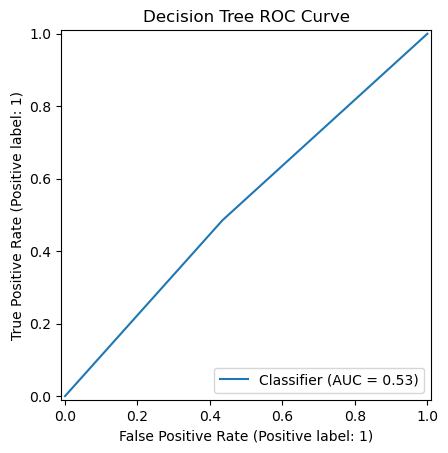


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.53      0.53        99
           1       0.53      0.53      0.53       101

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200



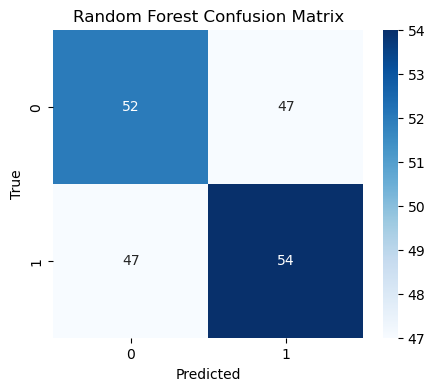

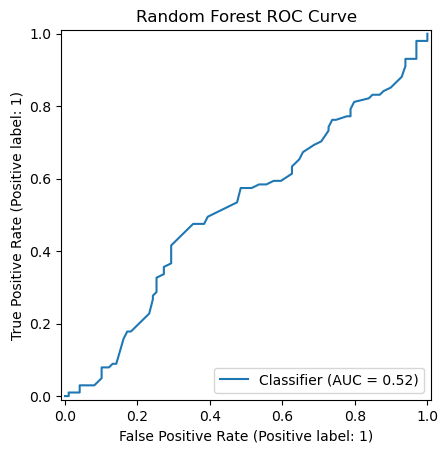


KNN Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.52      0.51        99
           1       0.51      0.50      0.50       101

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200



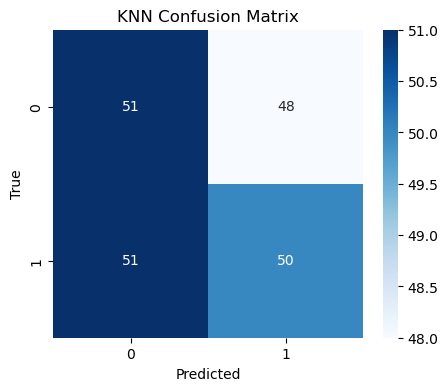

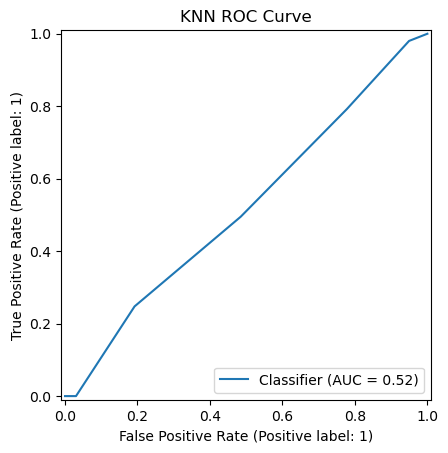

In [17]:
#Model Evaluation
# Display results in table
results_df = pd.DataFrame(results).T
print(results_df)

for name, pipe in zip(models.keys(), models.values()):
    # Re-fit to get pipe
    full_pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', models[name])
    ])
    full_pipe.fit(X_train, y_train)
    
    y_pred = full_pipe.predict(X_test)
    print(f'\n{name} Classification Report:\n')
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve
    if hasattr(full_pipe, 'predict_proba'):
        y_prob = full_pipe.predict_proba(X_test)[:, 1]
        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.title(f'{name} ROC Curve')
        plt.show()

Analysis & Conclusion
Based on the evaluation metrics, the Random Forest model performs the best with the highest F1-score and ROC-AUC, indicating strong overall performance in classifying patient satisfaction levels. This can be attributed to its ensemble nature, which handles non-linear relationships and feature interactions well, reducing overfitting compared to a single Decision Tree. Additionally, Random Forest is robust to class imbalance after SMOTE application and generalizes better on this dataset with mixed numerical and categorical features.
In contrast, simpler models like Logistic Regression provide interpretable results but may not capture complex patterns as effectively, leading to lower recall for the minority class. KNN and SVM show reasonable performance but are more sensitive to scaling and hyperparameters. Overall, for predicting patient satisfaction to improve hospital quality control, Random Forest is recommended, potentially with further hyperparameter tuning for enhanced accuracy.